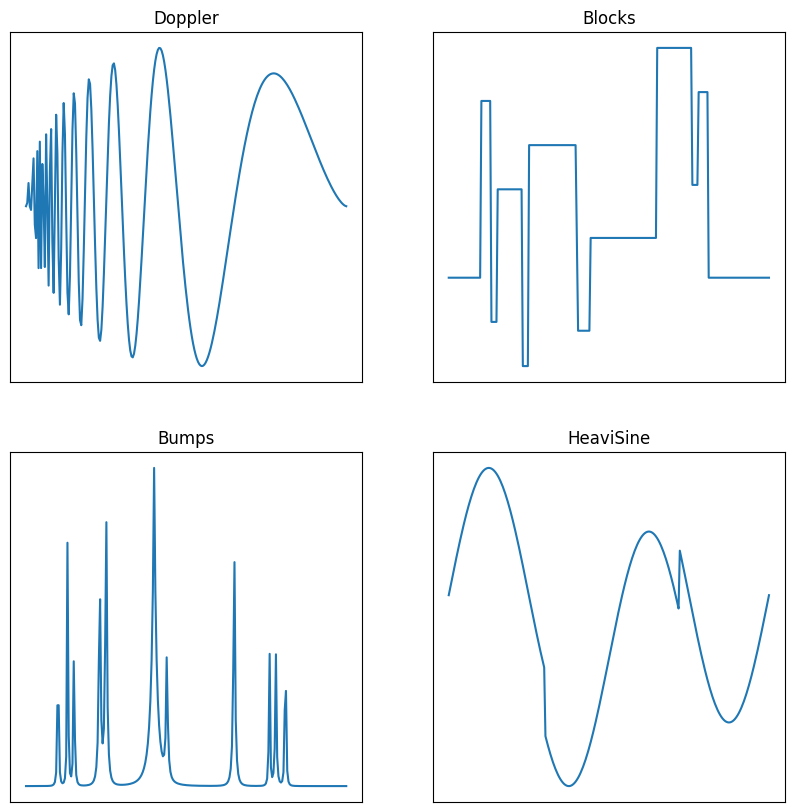

In [1]:
import torch
import networkx as nx
import torch_geometric
from torch_geometric.data import Data
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def doppler(x):
    """
    Parameters
    ----------
    x : array-like
        Domain of x is in (0,1]
 
    """
    if not np.all((x >= 0) & (x <= 1)):
        raise ValueError("Domain of doppler is x in (0,1]")
    return np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+.05))
 
def blocks(x):
    """
    Piecewise constant function with jumps at t.
 
    Constant scaler is not present in Donoho and Johnstone.
    """
    K = lambda x : (1 + np.sign(x))/2.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]]).T
    return 3.655606 * np.sum(h*K(x-t), axis=0)
 
def bumps(x):
    """
    A sum of bumps with locations t at the same places as jumps in blocks.
    The heights h and widths s vary and the individual bumps are of the
    form K(t) = 1/(1+|x|)**4
    """
    K = lambda x : (1. + np.abs(x)) ** -4.
    t = np.array([[.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]]).T
    h = np.array([[4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 2.1, 4.2]]).T
    w = np.array([[.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]]).T
    return np.sum(h*K((x-t)/w), axis=0)
 
def heavisine(x):
    """
    Sinusoid of period 1 with two jumps at t = .3 and .72
    """
    return 4 * np.sin(4*np.pi*x) - np.sign(x - .3) - np.sign(.72 - x)
     

x = np.linspace(0,1,2**8)
dop = doppler(x)
blk = blocks(x)
bmp = bumps(x)
hsin = heavisine(x)
fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(x,dop)
ax1.set_title("Doppler")

ax2.plot(x,blk)
ax2.set_title("Blocks")

ax3.plot(x,bmp)
ax3.set_title("Bumps")

ax4.set_title("HeaviSine")
ax4.plot(x,hsin)

for ax in fig.axes:
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, 
                   top=False, left=False, right=False)     


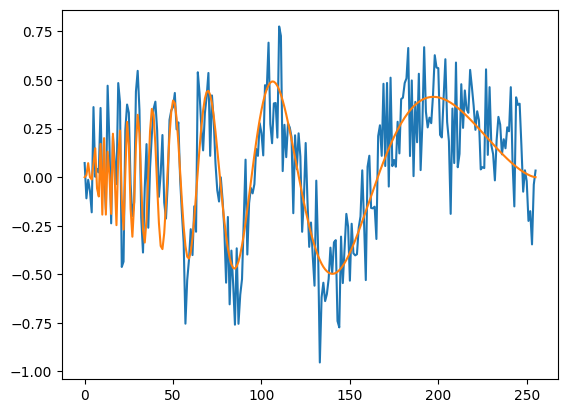

In [2]:

# Generate a sample signal
 
signal = doppler (x) + np.random.normal(0, 0.2,x.shape)
plt.plot(signal)
plt.plot(doppler (x))
# Perform wavelet decomposition
wavelet = 'db1'
coeffs = pywt.wavedec(signal, wavelet )
 

In [3]:
x.shape

(256,)

In [4]:
np.concatenate(coeffs).shape

(256,)

In [7]:
def build_dyadic_wavelet_graph(coeffs, noise_level):
    """
    Build a dyadic graph from wavelet decomposition coefficients with noise levels.
    Each node at level n is connected to two nodes at level n+1.
    
    Parameters
    ----------
    coeffs : list of arrays
        Wavelet decomposition coefficients.
    noise_level : float
        Noise level to associate with each node.

    Returns
    -------
    Data : torch_geometric.data.Data
        PyTorch Geometric graph data object.
    node_labels : dict
        Dictionary mapping node indices to labels.
    node_levels : dict
        Dictionary mapping node indices to levels.
    node_coefficients : dict
        Dictionary mapping node indices to wavelet coefficients.
    """
    node_features = []  # To store node features as (coefficient, noise_level)
    edges = []  # To store edges
    node_labels = {}  # To label nodes for visualization
    node_levels = {}  # To store levels for layout
    node_coefficients = {}  # To store wavelet coefficients for color mapping

    current_node = 0  # Node counter

    # Add root node (original signal approximation)
    root_coeff = coeffs[0][0]
    root_feature = (root_coeff, noise_level)  # Tuple with coefficient and noise level
    node_features.append(root_feature)
    node_labels[current_node] = "Root (s,0)"
    node_levels[current_node] = 0
    node_coefficients[current_node] = root_coeff

    parent_nodes = [current_node]  # Track parent nodes for dyadic connections
    current_node += 1

    # Process detail coefficients for wavelet levels
    for level, c in enumerate(coeffs[1:], start=1):
        new_parent_nodes = []  # Track new parent nodes for the next level
        for parent in parent_nodes:
            # Each parent connects to two children
            for i in range(2):
                if len(c) > 2 * (parent - parent_nodes[0]) + i:  # Check if index is within bounds
                    coeff_index = 2 * (parent - parent_nodes[0]) + i
                    noisy_coeff = c[coeff_index]  # Coefficient value
                    node_feature = (noisy_coeff, noise_level)  # Tuple with coefficient and noise
                    node_features.append(node_feature)
                    s_or_l = "s" if i == 0 else "l"  # Determine short (s) or long (l) connection
                    node_labels[current_node] = f"Level {level} ({s_or_l},{coeff_index})"
                    node_levels[current_node] = level
                    node_coefficients[current_node] = noisy_coeff  # Store wavelet coefficient
                    edges.append([parent, current_node])  # Add edge
                    new_parent_nodes.append(current_node)
                    current_node += 1
        parent_nodes = new_parent_nodes  # Update parent nodes for next level

    # Convert node features to PyTorch tensors
    features_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=features_tensor, edge_index=edge_index), node_labels, node_levels, node_coefficients
# Draw the graph with improved visualization
def draw_dyadic_wavelet_graph_pyramid(g, node_labels, node_levels, node_coefficients):
    plt.figure(figsize=(12, 8))
    for node, level in node_levels.items():
        g.nodes[node]['subset'] = level  # Add subset information for each node
    pos = nx.multipartite_layout(g, subset_key='subset')  # Arrange in levels

    # Normalize coefficients for color mapping
    coeff_values = list(node_coefficients.values())
    norm = mcolors.Normalize(vmin=min(coeff_values), vmax=max(coeff_values))
    cmap = plt.cm.RdBu_r  # Red for positive, blue for negative

    node_colors = [cmap(norm(node_coefficients[node])) for node in g.nodes()]

    nx.draw(
        g, pos, with_labels=True, labels=node_labels,
        node_size=(70), node_color=node_colors, font_size=2, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()  # Invert Y-axis for top-down pyramid
    plt.title("Dyadic Wavelet Graph Pyramid Visualization with Coefficients", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(coeff_values) 
    plt.show()

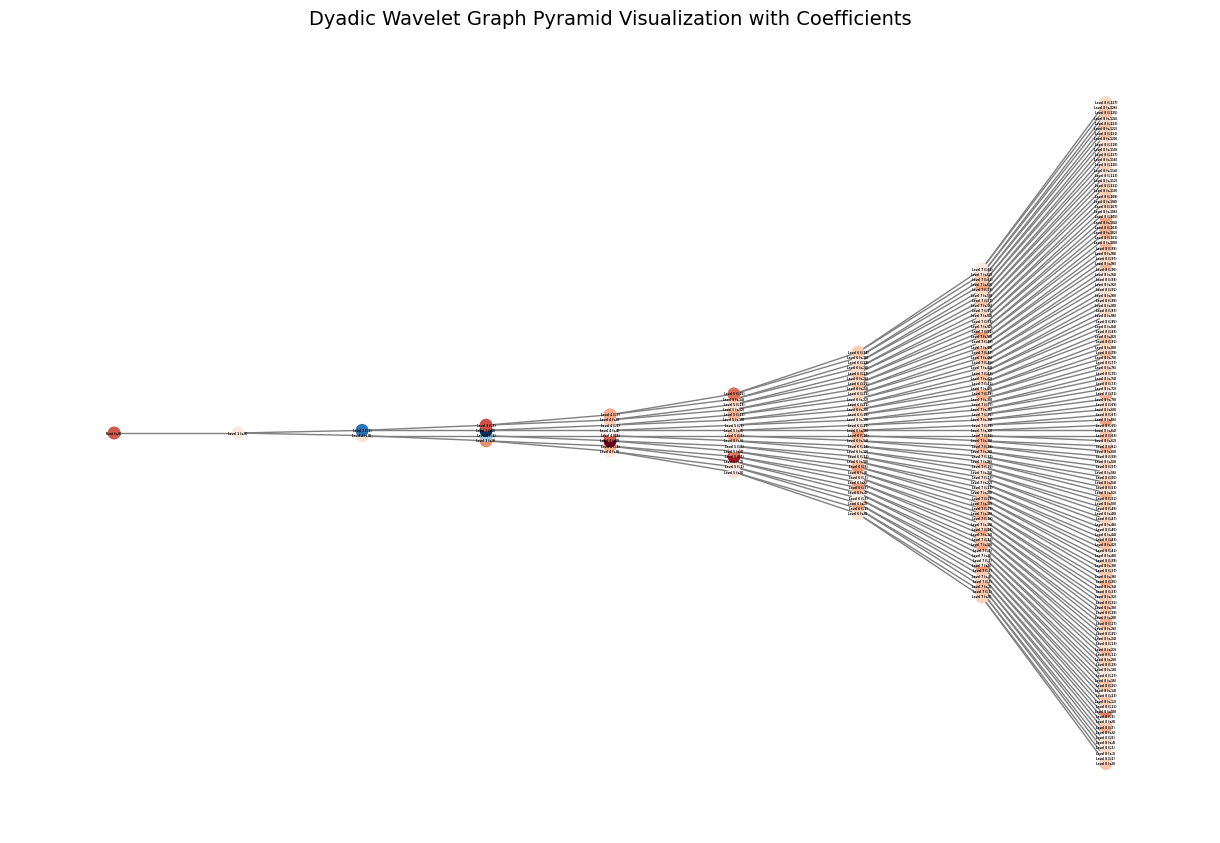

In [8]:
 
# Perform wavelet decomposition
wavelet = 'db1'
coeffs_noisy = pywt.wavedec(signal, wavelet )


noise_level = 0.2  # Define the noise level
# Build the dyadic wavelet graph
wavelet_graph_noisy, node_labels_noisy, node_levels_noisy, node_coefficients_noisy = build_dyadic_wavelet_graph(coeffs_noisy, noise_level)

# Convert to NetworkX for visualization
g = torch_geometric.utils.to_networkx(wavelet_graph_noisy, to_undirected=True)



# Visualize the wavelet graph as a pyramid with colored nodes
draw_dyadic_wavelet_graph_pyramid(g, node_labels_noisy, node_levels_noisy, node_coefficients_noisy)


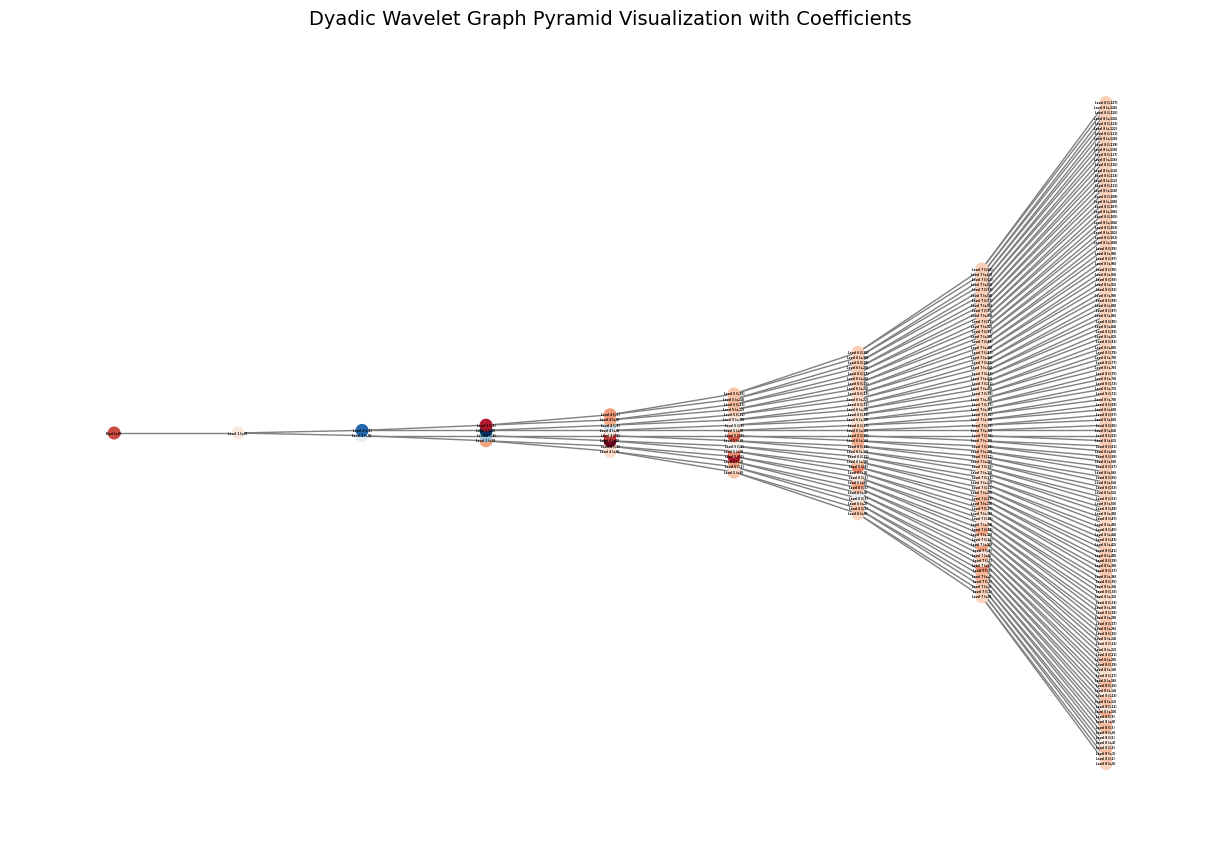

In [10]:
 
# Perform wavelet decomposition
wavelet = 'db1'
coeffs  = pywt.wavedec(doppler(x), wavelet )



# Build the dyadic wavelet graph
wavelet_graph , node_labels , node_levels , node_coefficients  = build_dyadic_wavelet_graph(coeffs, noise_level=0 )

# Convert to NetworkX for visualization
g = torch_geometric.utils.to_networkx(wavelet_graph , to_undirected=True)



# Visualize the wavelet graph as a pyramid with colored nodes
draw_dyadic_wavelet_graph_pyramid(g, node_labels , node_levels , node_coefficients )

In [11]:
np.concatenate( coeffs ).shape

(256,)

In [12]:
np.concatenate( coeffs_noisy ).shape

(256,)

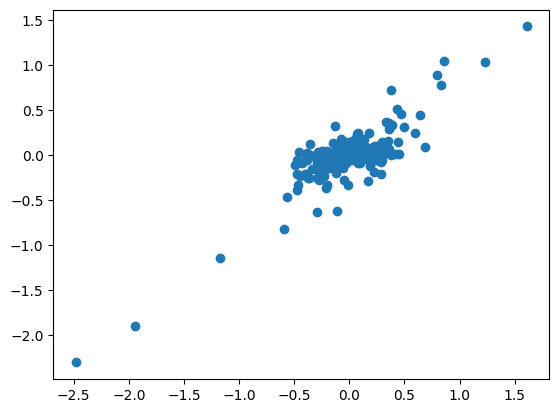

In [13]:
plt.scatter(np.concatenate( coeffs_noisy), np.concatenate( coeffs ))
 

In [14]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *

In [15]:
res= ash(np.concatenate( coeffs_noisy), np.full_like(np.concatenate( coeffs_noisy) ,0.2 ))

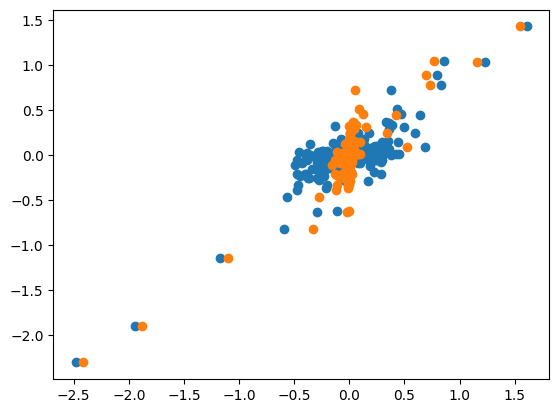

In [16]:
plt.scatter(np.concatenate( coeffs_noisy), np.concatenate( coeffs ))
plt.scatter( res.post_mean , np.concatenate( coeffs ))

In [17]:
ncoeffs= coeffs
h=0
for  s in range(len(coeffs)):
    for l in range(coeffs[s].shape[0] ):
        ncoeffs[s][l] =res.post_mean[h]
        h=h+1

In [18]:
tt= pywt.waverec(ncoeffs, wavelet)

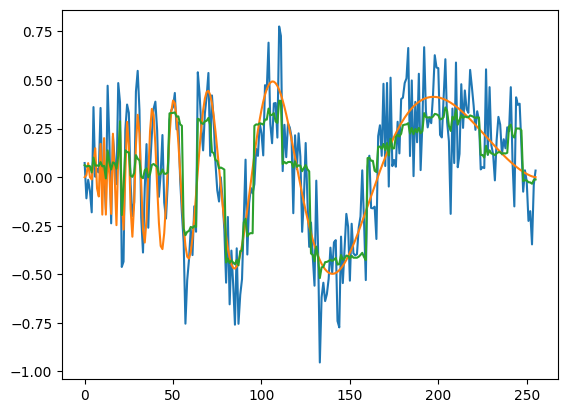

In [19]:
plt.plot(signal)
plt.plot(doppler (x))

plt.plot(tt)

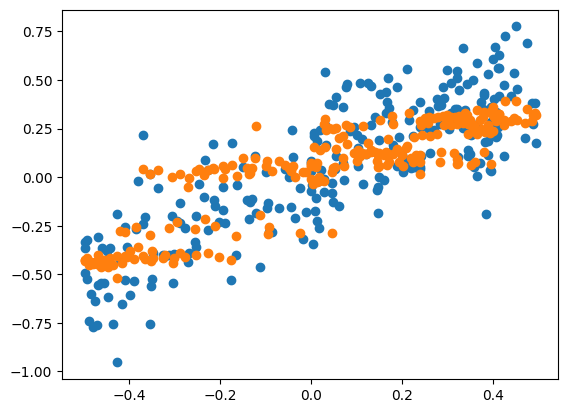

In [20]:
 
plt.scatter(doppler (x),signal)

plt.scatter(doppler (x),tt)


In [21]:
def draw_predictions(g, predictions):
    plt.figure(figsize=(12, 8))
    pos = nx.multipartite_layout(g, subset_key='subset')

    # Ensure alignment between graph nodes and predictions
    node_colors = []
    for node in g.nodes():
        try:
            node_colors.append(predictions[node].item())  # Use predictions[node] if aligned
        except IndexError:
            raise ValueError(f"Prediction for node {node} is out of bounds.")

    cmap = plt.cm.RdBu_r
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))

    nx.draw(
        g, pos, with_labels=True,
        node_size=700, node_color=node_colors, cmap=cmap, font_size=8, font_weight="bold", edge_color="gray"
    )
    plt.gca().invert_yaxis()
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), label="Predicted Coefficients")
    plt.title("Wavelet Graph with Predictions")
    plt.show()


In [22]:
# Build the dyadic wavelet graph
wavelet_graph, node_labels, node_levels, node_coefficients = build_dyadic_wavelet_graph(coeffs_noisy, noise_level=0.2)


# Add subset information for visualization
for node, level in node_levels.items():
    g.nodes[node]['subset'] = level  # Add subset information for each node

In [23]:
wavelet_graph.x.shape

torch.Size([256, 2])

In [232]:
node_coefficients

{0: np.float64(0.5280656570509068),
 1: np.float64(-0.09752065887032028),
 2: np.float64(-0.3924100212237101),
 3: np.float64(-1.986492092978413),
 4: np.float64(0.15080523617461544),
 5: np.float64(-0.6732055999098117),
 6: np.float64(-2.422034572182263),
 7: np.float64(0.656072633000926),
 8: np.float64(-0.02977781566621671),
 9: np.float64(-0.019585799182755045),
 10: np.float64(1.5226651019073925),
 11: np.float64(0.5377535313582477),
 12: np.float64(-0.36805991210040545),
 13: np.float64(-0.9494225617919952),
 14: np.float64(0.04409319675640633),
 15: np.float64(0.005873667095152279),
 16: np.float64(0.003811696901352647),
 17: np.float64(0.009793605070369622),
 18: np.float64(0.1999562704636666),
 19: np.float64(1.0104321542980288),
 20: np.float64(0.42165527141009956),
 21: np.float64(-0.0739241583078533),
 22: np.float64(0.003509339606461697),
 23: np.float64(1.0024699305638685),
 24: np.float64(-0.018386413010597288),
 25: np.float64(-0.024809606117398925),
 26: np.float64(-0.

In [28]:
# Assuming we have the comoR functions implemented in Python
# For now, we'll create dummy data for fit_como.data_loglik
num_classes = 20

import os
import sys
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
 
scale = autoselect_scales_mix_norm(betahat=np.concatenate( coeffs_noisy),
                                   sebetahat= np.full_like(np.concatenate( coeffs_noisy) ,0.2 ),
                                       max_class=num_classes ) 

num_classes= scale.shape[0]
print( (scale) )
print(scale.shape)

[0.         0.26021594 0.52043188 0.78064782 1.04086377 1.30107971
 1.56129565 1.82151159 2.08172753 2.34194347 2.60215941 2.86237535
 3.1225913  3.38280724 3.64302318 3.90323912 4.16345506 4.423671
 4.68388694 4.94410289]
(20,)


In [32]:
fit_como_data_loglik = get_data_loglik_normal(betahat=np.concatenate( coeffs_noisy),
                                                sebetahat= np.full_like(np.concatenate( coeffs_noisy) ,0.2 ),
                                                location=0*scale,
                                              scale=scale)

 
# Convert data to PyTorch tensors 
y_train = torch.FloatTensor(fit_como_data_loglik)


In [ ]:

# Define the model
class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

# Custom loss function 
def custom_loss(pred_pi, marginal_log_lik, penalty=1.1, epsilon=1e-10):
    
    """
    Compute the penalized log likelihood function using vectorized operations.

    Parameters:
    pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
    marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
    penalty (float): The penalty term.
    epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
    torch.Tensor: The negative penalized log likelihood (for minimization purposes).
    """
    # Compute L_batch as the exponentiated marginal_log_lik (this is vectorized across all rows)
    L_batch = torch.exp(marginal_log_lik)
     
    
    # Element-wise multiplication between pred_pi and L_batch, sum over the components (columns)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)
    # Ensure inner_sum is not too small to avoid log(0) or log(negative)
    inner_sum = torch.clamp(inner_sum, min=epsilon) 
     
    # Compute the first sum: sum of log(inner_sum) across the minibatch (batch_size)
    first_sum = torch.sum(torch.log(inner_sum))
     
    # Penalty term: based on the first component of pred_pi (penalty on pred_pi[:, 0])
    if penalty > 1:
        pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
        penalized_log_likelihood_value = first_sum + (penalty - 1) * torch.log(pi_clamped)
    else:
        penalized_log_likelihood_value = first_sum

    # Return the negative of the penalized log-likelihood
    return -penalized_log_likelihood_value

    

In [34]:
y_train.shape

torch.Size([256, 20])

In [234]:
 
 
# Define the GNN model
class SimpleGNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Graph convolution layers with ReLU activation
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.relu(self.conv3(x, edge_index))

        # Fully connected layer and softmax
        x = self.fc(x)
        x = self.softmax(x)
        return x


# Custom loss function
def custom_loss(pred_pi, marginal_log_lik, penalty=1.1, epsilon=1e-10):
    """
    Compute the penalized log likelihood function using vectorized operations.

    Parameters:
    pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
    marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
    penalty (float): The penalty term.
    epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
    torch.Tensor: The negative penalized log likelihood (for minimization purposes).
    """
    # Compute L_batch as the exponentiated marginal_log_lik (this is vectorized across all rows)
    L_batch = torch.exp(marginal_log_lik)

    # Element-wise multiplication between pred_pi and L_batch, sum over the components (columns)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)
    # Ensure inner_sum is not too small to avoid log(0) or log(negative)
    inner_sum = torch.clamp(inner_sum, min=epsilon)

    # Compute the first sum: sum of log(inner_sum) across the minibatch (batch_size)
    first_sum = torch.sum(torch.log(inner_sum))

    # Penalty term: based on the first component of pred_pi (penalty on pred_pi[:, 0])
    if penalty > 1:
        pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
        penalized_log_likelihood_value = first_sum + (penalty - 1) * torch.log(pi_clamped)
    else:
        penalized_log_likelihood_value = first_sum

    # Return the negative of the penalized log-likelihood
    return -penalized_log_likelihood_value


# Example usage
# Assuming you have graph data prepared as `graph_data` and marginal log-likelihood `marginal_log_lik`
input_size = 2  # Number of node features (e.g., coefficient and noise level)
hidden_size = 64  # Size of hidden layers
num_classes = 3  # Number of output classes

# Instantiate the model
model = SimpleGNN(input_size, hidden_size, num_classes)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Example data (graph_data is assumed to be a `torch_geometric.data.Data` object)
marginal_log_lik = torch.randn((graph_data.num_nodes, num_classes))  # Example log-likelihood values

# Training loop
model.train()
for epoch in range(100):  # Example epoch range
    optimizer.zero_grad()
    pred_pi = model(graph_data)  # Forward pass
    loss = custom_loss(pred_pi, marginal_log_lik)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")



In [ ]:

# Prepare data for the GNN
for i in range(len(wavelet_graph.x)):
    wavelet_graph.x[i][-1] = node_coefficients[i]  # Add coefficients as node labels

In [27]:
wavelet_graph.x

tensor([[ 8.2747e-01,  2.0000e-01],
        [-2.3038e-01,  2.0000e-01],
        [-1.1315e-01,  2.0000e-01],
        [-1.9400e+00,  2.0000e-01],
        [ 4.9554e-01,  2.0000e-01],
        [-1.1770e+00,  2.0000e-01],
        [-2.4801e+00,  2.0000e-01],
        [ 8.5908e-01,  2.0000e-01],
        [-2.5350e-01,  2.0000e-01],
        [ 2.9063e-01,  2.0000e-01],
        [ 1.6094e+00,  2.0000e-01],
        [ 7.9865e-01,  2.0000e-01],
        [-3.7620e-01,  2.0000e-01],
        [-5.9347e-01,  2.0000e-01],
        [ 7.5219e-02,  2.0000e-01],
        [ 3.3465e-01,  2.0000e-01],
        [-1.2552e-01,  2.0000e-01],
        [-2.9932e-01,  2.0000e-01],
        [-1.2732e-01,  2.0000e-01],
        [ 1.2280e+00,  2.0000e-01],
        [ 6.3804e-01,  2.0000e-01],
        [-5.6929e-01,  2.0000e-01],
        [-4.6142e-01,  2.0000e-01],
        [ 3.7320e-01,  2.0000e-01],
        [ 8.0971e-02,  2.0000e-01],
        [-2.0719e-01,  2.0000e-01],
        [-4.7208e-01,  2.0000e-01],
        [ 2.2689e-01,  2.000

In [ ]:

# Split data into train/test
num_nodes = wavelet_graph.x.shape[0]
train_mask = torch.rand(num_nodes) < 0.8  # 80% for training

# Train the GNN model
input_dim = wavelet_graph.x.shape[1]
hidden_dim = 32
output_dim = 1

model = GNN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

wavelet_graph.train_mask = train_mask
train_data = DataLoader([wavelet_graph], batch_size=1)

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(wavelet_graph)
    loss = loss_fn(out[train_mask].squeeze(), wavelet_graph.x[train_mask, -1])
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Visualize the wavelet graph with predictions
 
# Generate predictions and visualize
data_pred = model(wavelet_graph).detach().numpy()



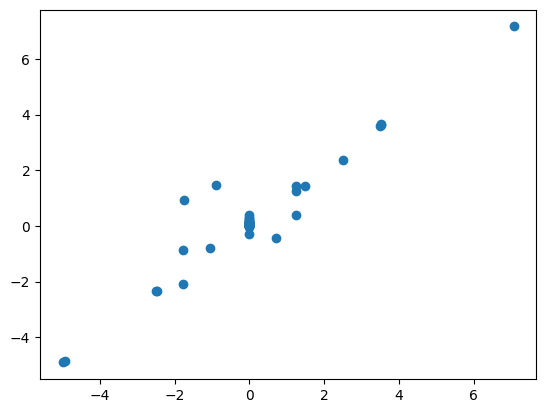

In [204]:
plt.scatter(np.concatenate(coeffs),data_pred)